In [1]:
!pip install opendatasets --quiet
import opendatasets as od
od.download('https://www.kaggle.com/datasets/emmarex/plantdisease')

Skipping, found downloaded files in ".\plantdisease" (use force=True to force download)



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import torch
from torch import nn
from torch.optim import Adam, SGD
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
import os

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [4]:
root_path = 'plantdisease/PlantVillage/'
img_path = []
labels_path = []

for label in os.listdir(root_path):
    for item in os.listdir(f'{root_path}/{label}'):
        img_path.append(f'{root_path}/{label}/{item}')
        labels_path.append(label)
        
print(f'Number of Images: {len(img_path)}')

Number of Images: 20638


In [5]:
# Creation of our Dataframe
data_df = pd.DataFrame(zip(img_path, labels_path), columns = ['image_path', 'label'])

# Print the distribution of data among classes and the format of our DataFrame.
print(data_df['label'].value_counts())
data_df.head()

label
Tomato__Tomato_YellowLeaf__Curl_Virus          3208
Tomato_Bacterial_spot                          2127
Tomato_Late_blight                             1909
Tomato_Septoria_leaf_spot                      1771
Tomato_Spider_mites_Two_spotted_spider_mite    1676
Tomato_healthy                                 1591
Pepper__bell___healthy                         1478
Tomato__Target_Spot                            1404
Potato___Early_blight                          1000
Potato___Late_blight                           1000
Tomato_Early_blight                            1000
Pepper__bell___Bacterial_spot                   997
Tomato_Leaf_Mold                                952
Tomato__Tomato_mosaic_virus                     373
Potato___healthy                                152
Name: count, dtype: int64


,image_path,label
0,plantdisease/PlantVillage//Pepper__bell___Bact...,Pepper__bell___Bacterial_spot
1,plantdisease/PlantVillage//Pepper__bell___Bact...,Pepper__bell___Bacterial_spot
2,plantdisease/PlantVillage//Pepper__bell___Bact...,Pepper__bell___Bacterial_spot
3,plantdisease/PlantVillage//Pepper__bell___Bact...,Pepper__bell___Bacterial_spot
4,plantdisease/PlantVillage//Pepper__bell___Bact...,Pepper__bell___Bacterial_spot


In [6]:
train = data_df.sample(frac=0.8)
val = data_df.drop(train.index)
test = val.sample(frac=0.5)
val = val.drop(test.index)

print(f'Train size: {len(train)}, Validation size: {len(val)}, Test size: {len(test)}')

Train size: 16510, Validation size: 2064, Test size: 2064


In [22]:
# Create a LabelEncoder for the Labels
label_encoder = LabelEncoder()
label_encoder.fit(data_df['label'])

# Create a transform for transforming the images in the same - appropriate form
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(dtype=torch.float)
])

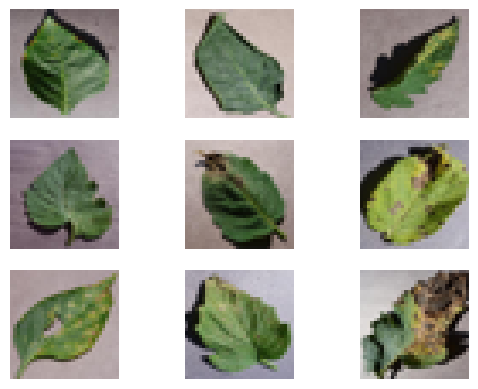

In [23]:
# Visualize the Images
n_rows = 3
n_cols = 3

f, axarr = plt.subplots(n_rows, n_cols)

for row in range(n_rows):
    for col in range(n_cols):
        image = Image.open(data_df.sample(n=1)["image_path"].iloc[0]).convert('RGB')
        image = image.resize((16, 16))
        axarr[row, col].imshow(image)
        axarr[row, col].axis('off')

plt.show()

In [24]:
class PlantsDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.labels = torch.tensor(label_encoder.transform(dataframe['label']), dtype=torch.long).to(device)
        
    def __len__(self):
        return self.dataframe.shape[0]
    
    def __getitem__(self, indx):
        image = Image.open(self.dataframe.iloc[indx, 0]).convert('RGB')
        
        if self.transform:
            image = self.transform(image).to(device)
        
        label = self.labels[indx]
        
        return image, label

In [25]:
train_data = PlantsDataset(train, transform=transform)
val_data = PlantsDataset(val, transform=transform)
test_data = PlantsDataset(test, transform=transform)

print(val_data.__getitem__(1500))

(tensor([[[0.6667, 0.6627, 0.6549,  ..., 0.5137, 0.5137, 0.5333],
         [0.6667, 0.6667, 0.6667,  ..., 0.5098, 0.5176, 0.5294],
         [0.6510, 0.6588, 0.6549,  ..., 0.5333, 0.5294, 0.5294],
         ...,
         [0.6980, 0.6902, 0.6863,  ..., 0.5373, 0.5294, 0.5176],
         [0.7020, 0.6784, 0.6784,  ..., 0.5294, 0.5098, 0.5059],
         [0.6824, 0.6667, 0.6588,  ..., 0.5216, 0.5098, 0.4980]],

        [[0.6235, 0.6196, 0.6118,  ..., 0.4667, 0.4667, 0.4863],
         [0.6235, 0.6235, 0.6235,  ..., 0.4627, 0.4706, 0.4824],
         [0.6078, 0.6157, 0.6078,  ..., 0.4784, 0.4824, 0.4824],
         ...,
         [0.6549, 0.6471, 0.6431,  ..., 0.4784, 0.4706, 0.4588],
         [0.6588, 0.6353, 0.6353,  ..., 0.4706, 0.4510, 0.4471],
         [0.6392, 0.6235, 0.6157,  ..., 0.4627, 0.4510, 0.4392]],

        [[0.6471, 0.6431, 0.6353,  ..., 0.4824, 0.4824, 0.5020],
         [0.6471, 0.6471, 0.6471,  ..., 0.4784, 0.4863, 0.4980],
         [0.6314, 0.6392, 0.6314,  ..., 0.4941, 0.4980, 0

In [26]:
Learning_Rate = 1e-3
Batch_Size = 16
Epochs = 100

train_loader = DataLoader(dataset=train_data, batch_size=Batch_Size, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=Batch_Size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=Batch_Size, shuffle=True)

In [38]:
# Models
class Plants(nn.Module):
    
    def __init__(self, number_of_classes):
        super().__init__()

        # Convolutions
        self.conv2d1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2d2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv2d3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv2d4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        # Maxpooling
        self.maxpooling = nn.MaxPool2d(kernel_size=2, stride=2)

        # Activation Function
        self.activation = nn.LeakyReLU()

        # Flatten Layer
        self.flatten = nn.Flatten()

        # Dense Layers
        self.dense1 = nn.Linear((128*16*16), 256)
        self.dense2 = nn.Linear(256, 128)
        self.dense3 = nn.Linear(128, 64)
        self.output = nn.Linear(64, number_of_classes)

    def forward(self, x):
                                    # x = (3, 256, 256)
        # Stage 1
        x = self.conv2d1(x)        # (16, 256, 256)
        x = self.maxpooling(x)     # (16, 128, 128)
        x = self.activation(x)     # (16, 128, 128)
        
        # Stage 2
        x = self.conv2d2(x)        # (32, 128, 128)
        x = self.maxpooling(x)     # (32, 64, 64)
        x = self.activation(x)     # (32, 64, 64)
    
        # Stage 3
        x = self.conv2d3(x)        # (64, 64, 64)
        x = self.maxpooling(x)     # (64, 32, 32)
        x = self.activation(x)     # (64, 32, 32)

        # Stage 4
        x = self.conv2d4(x)        # (128, 32, 32)
        x = self.maxpooling(x)     # (128, 16, 16)
        x = self.activation(x)     # (128, 16, 16)

        # Stage 5
        x = self.flatten(x)
        
        # Stage 6
        x = self.dense1(x)
        x = self.activation(x)
        
        # Stage 7
        x = self.dense2(x)
        x = self.activation(x)
        
        # Stage 8
        x = self.dense3(x)
        x = self.activation(x)
        
        # Stage 9
        x = self.output(x)
        
        return x
    
class Plants_Small(nn.Module):
    
    def __init__(self, number_of_classes):
        super().__init__()

        # Convolutions
        self.conv2d1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2d2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)

        # Maxpooling
        self.maxpooling = nn.MaxPool2d(kernel_size=2, stride=2)

        # Activation Function
        self.activation = nn.LeakyReLU()

        # Flatten Layer
        self.flatten = nn.Flatten()

        # Dense Layers
        self.dense = nn.Linear((32*4*4), 32)
        self.output = nn.Linear(32, number_of_classes)

    def forward(self, x):
                                    # x = (3, 256, 256)
        # Stage 1
        x = self.conv2d1(x)        # (16, 256, 256)
        x = self.maxpooling(x)     # (16, 128, 128)
        x = self.activation(x)     # (16, 128, 128)
        
        # Stage 2
        x = self.conv2d2(x)        # (32, 128, 128)
        x = self.maxpooling(x)     # (32, 64, 64)
        x = self.activation(x)     # (32, 64, 64)

        # Stage 5
        x = self.flatten(x)
        
        # Stage 6
        x = self.dense(x)        
        x = self.output(x)
        
        return x

In [39]:
# model =  Plants(len(data_df['label'].unique())).to(device)
model =  Plants_Small(len(data_df['label'].unique())).to(device)

In [40]:
from torchsummary import summary
summary(model, (3, 16, 16))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
         MaxPool2d-2           [-1, 16, 16, 16]               0
         LeakyReLU-3           [-1, 16, 16, 16]               0
            Conv2d-4           [-1, 32, 16, 16]           4,640
         MaxPool2d-5             [-1, 32, 8, 8]               0
         LeakyReLU-6             [-1, 32, 8, 8]               0
            Conv2d-7             [-1, 64, 8, 8]          18,496
         MaxPool2d-8             [-1, 64, 4, 4]               0
         LeakyReLU-9             [-1, 64, 4, 4]               0
           Conv2d-10            [-1, 128, 4, 4]          73,856
        MaxPool2d-11            [-1, 128, 2, 2]               0
        LeakyReLU-12            [-1, 128, 2, 2]               0
          Flatten-13                  [-1, 512]               0
           Linear-14                  [

In [41]:
criterion = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=Learning_Rate)

In [ ]:
import time
from tqdm import tqdm

total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []
time_plot = []

for epoch in range(Epochs):
    epoch_start = time.time()
    total_acc_train = 0
    total_loss_train = 0
    total_loss_val = 0
    total_acc_val = 0
    
    for images, labels in tqdm(train_loader):
        optimizer.zero_grad()
        
        outputs = model(images)
        
        train_loss = criterion(outputs, labels)
        total_loss_train += train_loss.item()
        
        train_loss.backward()
        train_acc = (torch.argmax(outputs, axis=1) == labels).sum().item()
        
        total_acc_train += train_acc
        optimizer.step()
        
    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            outputs = model(images)
            val_loss = criterion(outputs, labels)
            total_loss_val += val_loss.item()
            
            val_acc = (torch.argmax(outputs, axis=1) == labels).sum().item()
            total_acc_val += val_acc
            
    total_loss_train_plot.append(round(total_loss_train/1000, 4))
    total_loss_validation_plot.append(round(total_loss_val/1000, 4))
    
    total_acc_train_plot.append(round((total_acc_train/train_data.__len__()) * 100, 4))
    total_acc_validation_plot.append(round((total_acc_val/val_data.__len__()) * 100, 4))
      
    epoch_finish = round((time.time() - epoch_start)/60, 2)
        
    print(f'''Epoch {epoch+1}/{Epochs} Time: {epoch_finish} min, Train Loss: {round(total_loss_train/1000, 4)} Train Accuracy: {round((total_acc_train/train_data.__len__()) * 100, 4)}
              Validation Loss: {round(total_loss_val/1000, 4)} Validation Accuracy {round((total_acc_val/val_data.__len__()) * 100, 4)}
              ''')

100%|████████████████████████████████████████████████████████████████████████████████| 129/129 [00:04<00:00, 29.97it/s]


Epoch 1/100 Time: 0.73 min, Train Loss: 2.7927 Train Accuracy: 9.043
              Validation Loss: 0.3472 Validation Accuracy 15.6977
              


100%|████████████████████████████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 33.02it/s]


Epoch 2/100 Time: 0.77 min, Train Loss: 2.7714 Train Accuracy: 15.3967
              Validation Loss: 0.3447 Validation Accuracy 15.6977
              


100%|████████████████████████████████████████████████████████████████████████████████| 129/129 [00:04<00:00, 31.60it/s]


Epoch 3/100 Time: 0.66 min, Train Loss: 2.7533 Train Accuracy: 15.3967
              Validation Loss: 0.3425 Validation Accuracy 15.6977
              


100%|████████████████████████████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 34.22it/s]


Epoch 4/100 Time: 0.65 min, Train Loss: 2.7377 Train Accuracy: 15.3967
              Validation Loss: 0.3406 Validation Accuracy 15.6977
              


100%|████████████████████████████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 34.37it/s]


Epoch 5/100 Time: 0.65 min, Train Loss: 2.7243 Train Accuracy: 15.3967
              Validation Loss: 0.339 Validation Accuracy 15.6977
              


100%|████████████████████████████████████████████████████████████████████████████████| 129/129 [00:04<00:00, 31.56it/s]


Epoch 6/100 Time: 0.65 min, Train Loss: 2.7129 Train Accuracy: 15.3967
              Validation Loss: 0.3376 Validation Accuracy 15.6977
              


100%|████████████████████████████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 33.85it/s]


Epoch 7/100 Time: 0.65 min, Train Loss: 2.7032 Train Accuracy: 15.3967
              Validation Loss: 0.3364 Validation Accuracy 15.6977
              


100%|████████████████████████████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 34.61it/s]


Epoch 8/100 Time: 0.65 min, Train Loss: 2.6951 Train Accuracy: 15.3967
              Validation Loss: 0.3354 Validation Accuracy 15.6977
              


100%|████████████████████████████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 34.13it/s]


Epoch 9/100 Time: 0.66 min, Train Loss: 2.6882 Train Accuracy: 15.3967
              Validation Loss: 0.3346 Validation Accuracy 15.6977
              


100%|████████████████████████████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 33.86it/s]


Epoch 10/100 Time: 0.65 min, Train Loss: 2.6824 Train Accuracy: 15.3967
              Validation Loss: 0.3339 Validation Accuracy 15.6977
              


100%|████████████████████████████████████████████████████████████████████████████████| 129/129 [00:04<00:00, 31.62it/s]


Epoch 11/100 Time: 0.65 min, Train Loss: 2.6776 Train Accuracy: 15.3967
              Validation Loss: 0.3333 Validation Accuracy 15.6977
              


100%|████████████████████████████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 33.72it/s]


Epoch 12/100 Time: 0.65 min, Train Loss: 2.6737 Train Accuracy: 15.3967
              Validation Loss: 0.3328 Validation Accuracy 15.6977
              


100%|████████████████████████████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 33.72it/s]


Epoch 13/100 Time: 0.62 min, Train Loss: 2.6703 Train Accuracy: 15.3967
              Validation Loss: 0.3324 Validation Accuracy 15.6977
              


100%|████████████████████████████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 34.39it/s]


Epoch 14/100 Time: 0.65 min, Train Loss: 2.6676 Train Accuracy: 15.3967
              Validation Loss: 0.332 Validation Accuracy 15.6977
              


100%|████████████████████████████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 34.16it/s]


Epoch 15/100 Time: 0.64 min, Train Loss: 2.6652 Train Accuracy: 15.3967
              Validation Loss: 0.3317 Validation Accuracy 15.6977
              


100%|████████████████████████████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 34.47it/s]


Epoch 16/100 Time: 0.63 min, Train Loss: 2.6632 Train Accuracy: 15.3967
              Validation Loss: 0.3315 Validation Accuracy 15.6977
              


100%|████████████████████████████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.01it/s]


Epoch 17/100 Time: 0.65 min, Train Loss: 2.6615 Train Accuracy: 15.3967
              Validation Loss: 0.3312 Validation Accuracy 15.6977
              


100%|████████████████████████████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.15it/s]


Epoch 18/100 Time: 0.57 min, Train Loss: 2.66 Train Accuracy: 15.3967
              Validation Loss: 0.331 Validation Accuracy 15.6977
              


100%|████████████████████████████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 39.08it/s]


Epoch 19/100 Time: 0.57 min, Train Loss: 2.6588 Train Accuracy: 15.3967
              Validation Loss: 0.3309 Validation Accuracy 15.6977
              


 36%|████████████████████████████▍                                                  | 372/1032 [00:11<00:20, 32.73it/s]

In [17]:
# Save the trained model
torch.save(model.state_dict(), "plants_model_pico_resized.pt")

In [20]:
# Load the model
model =  Plants_Small(len(data_df['label'].unique())).to(device)
model.load_state_dict(torch.load("plants_model_pico_resized.pt"))

from torchsummary import summary
summary(model, (3, 16, 16))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 16, 16]             448
         MaxPool2d-2             [-1, 16, 8, 8]               0
         LeakyReLU-3             [-1, 16, 8, 8]               0
            Conv2d-4             [-1, 32, 8, 8]           4,640
         MaxPool2d-5             [-1, 32, 4, 4]               0
         LeakyReLU-6             [-1, 32, 4, 4]               0
           Flatten-7                  [-1, 512]               0
            Linear-8                   [-1, 32]          16,416
            Linear-9                   [-1, 15]             495
Total params: 21,999
Trainable params: 21,999
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 0.08
Estimated Total Size (MB): 0.16
---------------------------------------------

In [21]:
# Evaluation of the trained model

from tqdm import tqdm
import time

total_loss_test = 0
total_acc_test = 0
inference_time = []

with torch.no_grad():
    for images, labels in tqdm(test_loader):
        
        start = time.time()
        outputs = model(images)
        inference_t = round((time.time() - start), 2)
        inference_time.append(inference_t)
        
        test_loss = criterion(outputs, labels)
        total_loss_test += test_loss.item()

        test_acc = (torch.argmax(outputs, axis=1) == labels).sum().item()
        total_acc_test += test_acc
        
print(f"Test Loss: {round(total_loss_test/1000, 4)}, Test Accuracy: {round(total_acc_test/test_data.__len__()*100, 4)}, Inference Time: {round(sum(inference_time)/len(inference_time), 4)} seconds")

100%|████████████████████████████████████████████████████████████████████████████████| 129/129 [00:04<00:00, 29.48it/s]

Test Loss: 0.096, Test Accuracy: 75.969, Inference Time: 0.0 seconds


In [ ]:
# Quantization and pruning of the trained model


In [ ]:
# Conversion to tflite mode of the trained model
